In [1]:
import torch

from src.data.project4.dataloader import get_loaders 
from src.models.project4.models import get_model
from src.utils import set_seed, get_optimizer
from src.models.project4.losses import get_loss

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from omegaconf import OmegaConf


In [2]:
torch.cuda.is_available()

True

In [3]:
args = OmegaConf.create({
    'model_name': 'resnet18',
    'region_size': 224,
    'batch_size': 1,
    'optimizer': 'Adam',
    'loss': 'CrossEntropy',
    'data_path': '/work3/s194253/02514/project4_results/data_wastedetection',
    'use_super_categories': True,
    'lr': 1e-04,
    'out': False,
    'seed': 0,
    'verbose': False,
    'percentage_to_freeze': None,
})

device = torch.device('cuda:0')
device = torch.device('cpu')

In [4]:
set_seed(args.seed)

In [5]:
# Get data loaders with applied transformations
loaders, num_classes = get_loaders(
    dataset='waste', 
    batch_size=args.batch_size, 
    seed=args.seed, 
    num_workers=1,
    img_size = (512, 512),
    region_size = (args.region_size, args.region_size),
    use_super_categories=args.use_super_categories,
    root = args.data_path,
)

id2cat = loaders['train'].dataset.id2cat

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [6]:
loss_fun = get_loss(args.loss)
optimizer = get_optimizer(args.optimizer)

model = get_model(args.model_name, args, loss_fun, optimizer, out=args.out, num_classes=num_classes, region_size=(args.region_size, args.region_size), id2cat=loaders['train'].dataset.id2cat)

In [7]:
BASE_PATH = '/work3/s194253/02514/project4_results/logs/albertkjoller_efficientnet_crossentropy_resnet/resnet18/albertkjoller_efficientnet_crossentropy_resnet/resnet18/'


VERSION = 0
EPOCH_NAME = 'epoch=6_loss_val=0.3089.ckpt'

checkpoint_path = BASE_PATH + f'version_{VERSION}/checkpoints/' + EPOCH_NAME

model = model.load_from_checkpoint(checkpoint_path, loss_fun=loss_fun)
model.eval()
model.to(device)
print("Checkpoint loaded!")

Checkpoint loaded!


In [8]:
from src.utils import plot_SS
from torchvision.ops import box_iou, nms

In [9]:
batch_idx = 1
batch = loaders['test'].dataset.__getitem__(batch_idx)

# for each image
i = 0
(img, cat_ids, bboxes_data, pred_bboxes_data) = batch

# for each bounding box
(bboxes, regions)           = bboxes_data # - not available at this point
(pred_bboxes, pred_regions) = pred_bboxes_data

# Classify proposed regions
y_hat = model.forward(pred_regions.to(device))

# maximum probabilities
outputs = torch.nn.functional.softmax(y_hat, dim=1)
pred_prob, pred_cat = torch.max(outputs, 1)

print("pred_cat:", pred_cat)

# Applying NMS (remove redundant boxes)
keep_indices = nms(pred_bboxes.to(torch.float).to(device), pred_prob, 0.5).cpu()

# Computing AP
preds = {'boxes': pred_bboxes.cpu()[keep_indices][pred_cat.cpu()[keep_indices] != max(model.id2cat.keys())], 
        'scores': pred_prob.cpu()[keep_indices][pred_cat.cpu()[keep_indices]   != max(model.id2cat.keys())], 
        'labels': pred_cat.cpu()[keep_indices][pred_cat.cpu()[keep_indices]    != max(model.id2cat.keys())]} 

targets = {
    'boxes':  bboxes, 
    'labels': cat_ids.flatten()
}

pred_cat: tensor([28, 28, 28, 28,  1, 28, 28, 28, 28, 25, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28,  1, 28, 28, 28, 28, 28, 28,  1, 28, 28, 28, 28, 28, 28,  1, 19,
        28,  0, 28, 28,  1, 28, 28, 28, 28, 28, 19, 28, 19, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28,  1, 26, 19, 28, 28, 28,  1,  1, 28, 28, 28, 28,
        28, 28, 28, 28, 28,  0, 28, 28, 28, 28, 28, 28, 28,  1, 28, 28, 28,  1,
        28, 28, 28, 28, 28,  1, 28, 28,  1, 28, 19, 28, 19, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 19, 28, 28,  0,  1, 28, 28, 28, 28,  1, 28,  1, 28, 28,
        28,  0, 28, 28, 28, 28, 28, 28, 28, 28,  1,  1, 28,  1, 28, 28, 28, 28,
        28, 28, 19, 28, 28,  0, 28, 28, 28])


In [10]:
preds['labels']

tensor([ 0,  0,  1, 19,  1, 25, 26,  1,  1,  1, 19, 19])

In [41]:
plot_SS(
    img, 
    targets['boxes'].detach().cpu(), 
    targets['labels'].detach().cpu(), 
    preds['boxes'].detach().cpu(), 
    preds['labels'].detach().cpu(), 
    preds['scores'].detach().cpu(),
    i,
    batch_idx,
    id2cat,
    path = './'
)

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [22]:
pred_matches, gt_matches, box_labels, gt2pred = model.compare_boxes(bboxes, cat_ids, pred_bboxes, num_classes)

In [23]:
preds['labels'][box_labels[keep_indices] != 28]

IndexError: The shape of the mask [71] at index 0 does not match the shape of the indexed tensor [12] at index 0

ValueError: Found input variables with inconsistent numbers of samples: [1, 12]

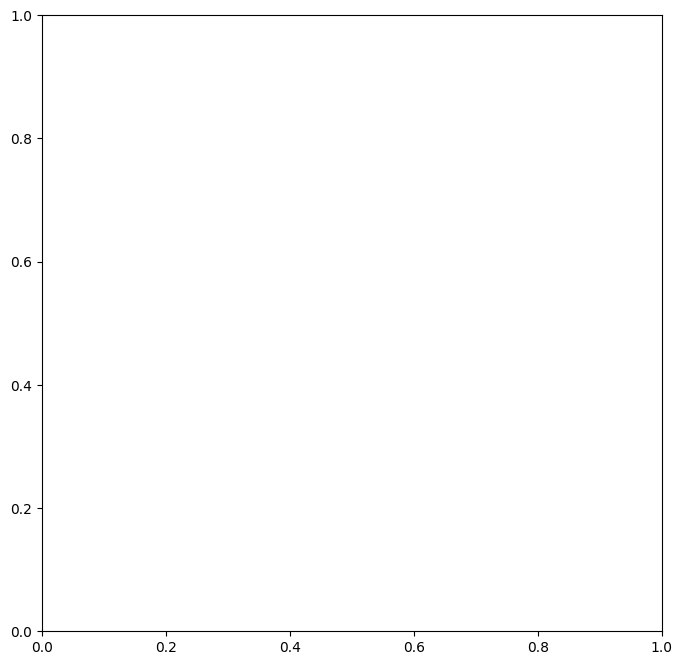

In [15]:
def conf_mat(preds, targets, classes, idx):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    cm = confusion_matrix(targets, preds, labels=list(classes.keys()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=classes.values())
    path = '/work3/s184984/02514/project4_results/predict_imgs'
    # disp.ax_.rotate_yticklabels(20)
    folder_path = f"{path}/{path.split('/')[-1]}_batchidx{batch_idx}"
    # plt.savefig(f'{folder_path}/idx{idx}.png', dpi=300, bbox_inches='tight')
    disp.plot(xticks_rotation=0.2)

conf_mat(preds['labels'], targets['labels'], id2cat, 0)

In [ ]:


fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(img.permute(1,2,0))
for i, bbox in enumerate(preds['boxes'][preds['labels'] != 28]):
    rect = patches.Rectangle(
        (bbox[0].item(), bbox[1].item()), 
        width=(bbox[2] - bbox[0]).item(), 
        height=(bbox[3] - bbox[1]).item(), 
        linewidth=2, 
        edgecolor=f"r", 
        facecolor='none'
    )
    ax.add_patch(rect)

for i, bbox in enumerate(targets['boxes']):
    rect = patches.Rectangle(
        (bbox[0].item(), bbox[1].item()), 
        width=(bbox[2] - bbox[0]).item(), 
        height=(bbox[3] - bbox[1]).item(), 
        linewidth=2, 
        edgecolor=f"b", 
        facecolor='none'
    )
    ax.add_patch(rect)
    
plt.show()
plt.close()
fig.close()

In [ ]:
checkpoint_path = '/work3/s194253/02514/project4_results/logs/albertkjoller_efficientnet/efficientnet_b4/albertkjoller_efficientnet/efficientnet_b4/version_2/checkpoints/epoch=28_val_loss=0.0000.ckpt'

model.load_from_checkpoint(checkpoint_path)